In [1]:
import numpy as np
import pandas as pd
from skimage import io
import os
from tqdm import tqdm_notebook
from outliers import smirnov_grubbs as grubbs
import itertools
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.getcwd()
if ROOT_DIR.endswith("notebooks"):
    # Go up one level to the repo root
    os.chdir(os.path.dirname(ROOT_DIR))
    
# Import unet library
sys.path.append(ROOT_DIR)
from unet import utils

%matplotlib inline

# Quantification and statistics for Figure 3 and 4

In [2]:
LAB = 'wue1'
init = 'from-scratch'
MIN_PIXEL = 30
MASK = 'cFOS'
AREA = 'NeuN'
GROUPS = {'H' : 0, '-' : 1, '+' : 2}
OUTLIERS_INT = [19]
OUTLIERS = [1438]

## Measure ROIs and area for all predictions

In [ ]:
# Set paths and get model names
data_path = 'bioimage_data/lab-{}/images'.format(LAB)
mask_path = 'bioimage_data/lab-{}/labels'.format(LAB)
area_path = 'bioimage_data/lab-{}/regions'.format(LAB)
area_subfolder = ['CA1-CA3-DG_whole', 'CA1-CA3-DG_whole', 'CA1-CA3-DG_whole', 'DG_supra', 'DG_infra']
areas = ['CA1', 'CA3', 'DG','DG', 'DG']
subareas = ['CA1', 'CA3', 'DG','DG_supra', 'DG_infra']
ens_list = [x for x in next(os.walk(os.path.join(mask_path,init)))[1] if not x.startswith('.')]
assignment = pd.read_excel('bioimage_data/image_mapping.xlsx', converters={'Nummer': lambda x: str(x).zfill(4)})

df_all = []
for subfold, area, subarea in zip(area_subfolder, areas, subareas):
    print(area, subarea)
    
    # Filter for regions
    df_zu = assignment[(assignment['Genotyp']=='WT') & 
                       (assignment['region']=='dHC') & 
                       (assignment['Area'].isin([area])) & 
                       (assignment['Experiment'].isin([1,2,3,4])) &
                       (assignment['Cross-coder Training'].isna()) & 
                       (assignment['Ausschluss von Analyse'].isna()) &
                       (assignment['broken'].isna())]
    file_ids = df_zu['Nummer'].tolist()
    
    # Load images and areas
    image_list = [io.imread(os.path.join(data_path, img_name), as_gray=True) for 
                  img_name in [s + '.tif' for s in file_ids]]
    area_list = [io.imread(os.path.join(area_path, subfold, img_name), as_gray=True) for 
              img_name in [s + '_' + AREA + '.tif' for s in file_ids]]
    
    # Load and measure area
    df_area_list = [utils.measure_rois(msk, img, fid) for msk, img, fid in zip(area_list, image_list, file_ids)]
    df_area = pd.concat(df_area_list)
    df_area.rename({'area': 'region_area'}, axis='columns', inplace=True)
    
    df_roi_list = []
    for ens in tqdm_notebook(ens_list):
        fold_list = [x for x in next(os.walk(os.path.join(mask_path, init, ens)))[1] if not x.startswith('.')]
        model_list = [[x for x in next(os.walk(os.path.join(mask_path, init, ens, fold)))[1] if not x.startswith('.')][0] for fold in fold_list]
        for fold, model in zip(fold_list, model_list):
            model_path = os.path.join(mask_path, init, ens, fold, model)
            
            # Load masks
            mask_list = [io.imread(os.path.join(model_path, x), as_gray=True).astype('int') for x in [s + '_' + MASK + '.png' for s in file_ids]]
            
            # Cut irrelevant regions
            for msk, area in zip(mask_list, area_list):
                msk[area==0]=0
                
            # Measure ROIs
            df_list = [utils.measure_rois(msk, img, fid, min_pixel=MIN_PIXEL) for msk, img, fid in zip(mask_list, image_list, file_ids)]
            
            # Create output df
            df_tmp = pd.concat(df_list)
            df_tmp['model'] = fold
            df_tmp['unet'] = model
            df_tmp['ens'] = ens
            df_roi_list += [df_tmp]
            
    df_roi = pd.concat(df_roi_list)    
    df_roi['subarea'] = subarea
    df_roi['init'] = init
    df_roi = pd.merge(df_roi, df_area[['Nummer','region_area']], how='left', on='Nummer')
    df_all += [df_roi]

df_all = pd.concat(df_all)
df_all.to_csv(os.path.join('source_data', 'fig_4', 'ROIs_'+LAB+'.csv'), index=False) 

## Combine results with experimental data

In [4]:
#Load Data
assignment = pd.read_excel('bioimage_data/image_mapping.xlsx')
df_zu = assignment[(assignment['Genotyp']=='WT')&
                    (assignment['region']=='dHC')&
                    (assignment['Area'].isin(['CA1', 'CA3', 'DG']))&
                    (assignment['region']=='dHC')&
                    (assignment['Experiment'].isin([1,2,3,4]))&
                    (assignment['Cross-coder Training'].isna()) & 
                    (assignment['Ausschluss von Analyse'].isna()) &
                    (assignment['broken'].isna())].copy()
df_zu['Group'] = df_zu['Kondition'].transform(lambda x: GROUPS[x])

# Merge Data
df_all = pd.read_csv(os.path.join('source_data', 'fig_4', 'ROIs_'+LAB+'.csv'))
df = (df_all.groupby(['subarea', 'ens', 'unet', 'model','init', 'Nummer'])
      .agg({'mean_intensity' : ['mean', 'count'], 'region_area' : ['mean']}))
df = df.join(df_zu.set_index('Nummer')[['Kondition', 'Group', 'Experiment']], how='left', on='Nummer')
df = df.rename(columns={('mean_intensity', 'count'): 'count', ('region_area', 'mean'): 'Neun_Area', ('mean_intensity', 'mean'): 'mean'})
df['cfos_per_area'] = df['count']/df['Neun_Area']

## Check for outliers

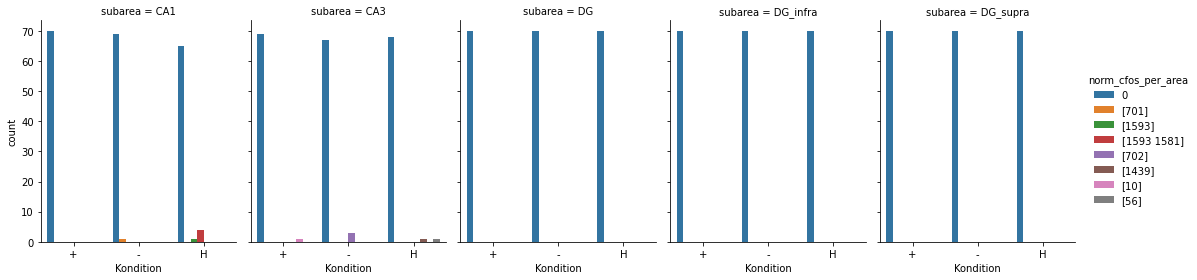

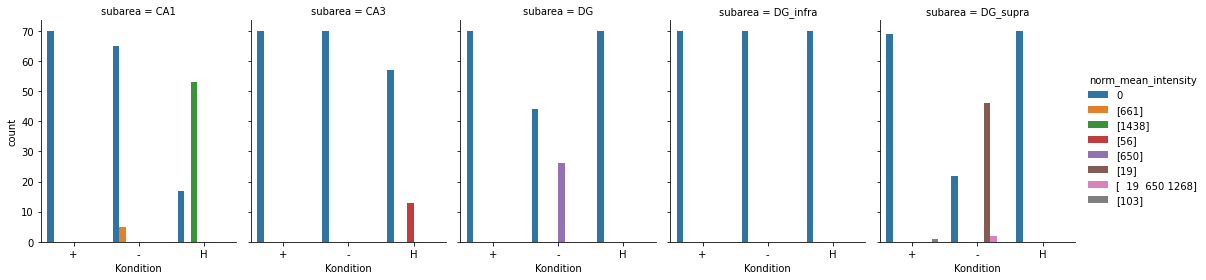

In [12]:
df_out = df.copy()

# Normalize data
ctlr_norm = (df_out[df_out.Group == 0]
             .groupby(['subarea', 'ens', 'unet', 'model', 'init', 'Experiment'])[['cfos_per_area', 'mean']]
             .agg(np.mean))
df_out = (df_out.reset_index()
          .set_index(['subarea', 'ens', 'unet', 'model','init','Experiment', 'Nummer'])
          .join(ctlr_norm, rsuffix='_ctrl'))
df_out['norm_cfos_per_area'] = df_out['cfos_per_area']/df_out['cfos_per_area_ctrl']
df_out['norm_mean_intensity'] = df_out['mean']/df_out['mean_ctrl']

# Helper functions
def get_outlier_names(x):
    out_ind = grubbs.two_sided_test_indices(x, alpha=0.05)
    if len(out_ind)>0:
        return str(x.iloc[out_ind].index.get_level_values('Nummer').values)
    else:
        return '0'

# Plot data
df_plot = (df_out
           .groupby(['subarea','unet', 'init','Kondition'])[['norm_cfos_per_area', 'norm_mean_intensity']]
           .agg(get_outlier_names).reset_index())

g = sns.catplot(x='Kondition', hue='norm_cfos_per_area', col='subarea',
            data=df_plot, kind="count",dodge=True, height=4, aspect=0.75)

g = sns.catplot(x='Kondition', hue='norm_mean_intensity', col='subarea',
            data=df_plot, kind="count",dodge=True, height=4, aspect=0.75)

## Remove outliers

In [5]:
# Remove Outliers ()
df = df[~df.index.get_level_values('Nummer').isin(OUTLIERS)]
df.loc[df.index.get_level_values('Nummer').isin(OUTLIERS_INT), 'mean'] = np.nan

# Normalize data
ctlr_norm = (df[df.Group == 0]
             .groupby(['subarea', 'ens', 'unet', 'model', 'init', 'Experiment'])[['cfos_per_area', 'mean']]
             .agg(np.mean))
df = (df.reset_index()
          .set_index(['subarea', 'ens', 'unet', 'model','init','Experiment', 'Nummer'])
          .join(ctlr_norm, rsuffix='_ctrl'))
df['norm_cfos_per_area'] = df['cfos_per_area']/df['cfos_per_area_ctrl']
df['norm_mean_intensity'] = df['mean']/df['mean_ctrl']

Save to Figure source data

In [6]:
# Figure 4
df.to_csv('source_data/fig_4/quantifications_wue1.csv'.format(LAB))

# Figure 3
fig3_ens = ['wue1_consensus4_ensemble', 'wue1_consensus5_ensemble',
            'wue1_consensus7_3.0007.h5', 'wue1_consensus1_3.0008.h5',
            'wue1_expert4_3.0008.h5', 'wue1_expert2_4.0011.h5']
df3 = df.reset_index()
(df3[(df3.subarea=='CA1') & (df3.unet.isin(fig3_ens))]
 .to_csv('source_data/fig_3/quantifications_CA1_wue1.csv'.format(LAB), index=False))

## Compute statistics

In [7]:
df_list = []
c_alpha = 0.05
c_alpha_list = [0.01, 0.001]
for key2, grp2 in tqdm_notebook(df.groupby(['ens', 'unet', 'model','init', 'subarea'])):

    for m in ['norm_cfos_per_area', 'norm_mean_intensity']:
        res_dict = {'subarea': [key2[4]], 'ens': [key2[0]], 
                    'unet': [key2[1]], 'init': [key2[3]],
                    'model': [key2[2]], 'type': [m]}
        
        df_fil = grp2[~grp2[m].isna()]
        
        if all(df_fil.groupby('Group').size()>3):
            grp_data = [x[1] for x in df_fil.groupby('Group', sort=True)[m]]
            n_groups = len(grp_data)
            
            # Get Group Means/Median
            grp_means = [x.mean() for x in grp_data]   
            res_dict['grp_mean_1'] = grp_means[0]
            res_dict['grp_mean_2'] = grp_means[1]
            res_dict['grp_mean_3'] = grp_means[2]
            grp_medians = [x.median() for x in grp_data]       
            
            # Perform the Shapiro-Wilk test for normality.
            grp_norms = [x[1] for x in map(stats.shapiro, grp_data)]
            
            #Check for equality of variances
            if len(grp_data)>2:
                _, levene = stats.levene(*grp_data, center = 'mean')
            else:
                _, levene = stats.levene(*grp_data, center = 'median')
            
            # Anova possible?
            anova = True if all(np.array([*grp_norms,levene])> 0.05) else False
            res_dict['anova_ok'] = [anova]
            
            # Only 3 groups tests
            if n_groups==3: 
                
                # kruskal all groups
                H, kwa_p_value = stats.kruskal(*grp_data)
                N = len(df_fil)
                
                kwa_eta_squared = (H - n_groups + 1)/(N-n_groups) # http://tss.awf.poznan.pl/files/3_Trends_Vol21_2014__no1_20.pdf
                # kwa_eta_squared = ((H / (n_groups-1)) * (n_groups-1)) / ((H / (n_groups-1)) * (n_groups-1) + (N-n_groups)) 
                #For references, see: https://www.researchgate.net/post/Anyone_know_how_to_calculate_eta_squared_for_a_Kruskal-Wallis_analysis
                res_dict['H_kwa_all'] = [H]
                res_dict['eta^2_kwa_all'] = [kwa_eta_squared]
                res_dict['p_kwa_all'] = [kwa_p_value]
                res_dict['kwa_all'] = 1 if kwa_p_value<0.05 else 0
                # Critical Value
                p = 1-c_alpha
                ddof = n_groups-1
                H_c = stats.chi2.ppf(p, ddof) 
                kwa_eta_squared_c = (H_c- n_groups + 1)/(N-n_groups) 
                res_dict['c_kwa_all'] = [kwa_eta_squared_c]
                
            # Pairwise tests
            for i,j in itertools.combinations(range(len(grp_data)), 2):
                k, l = i+1, j+1
                
                # Pairwise mannwhitneyu tests
                U, mwu_p_value = stats.mannwhitneyu(grp_data[i],grp_data[j], alternative = 'two-sided')
                n_1 = grp_data[i].count()
                n_2 = grp_data[j].count()
                N = n_1 + n_2
                mwu_eta_squared = ((U - (n_1*n_2/2)) / np.sqrt((n_1*n_2*(n_1+n_2+1))/12) / np.sqrt(n_1+n_2))**2
                # according to http://www.statisticslectures.com/topics/mannwhitneyu/ & cross-checked with Origin & psychometrica
                res_dict['U_mwu{}_vs_{}'.format(k,l)] = [U]
                res_dict['eta^2_mwu{}_vs_{}'.format(k,l)] = [mwu_eta_squared]
                res_dict['p_mwu{}_vs_{}'.format(k,l)] = [mwu_p_value]
                # Critical Value
                p = 1-c_alpha if n_groups==2 else 1-(c_alpha/n_groups)
                U_c = stats.chi2.ppf(p, 1)
                mwu_eta_squared_c = U_c/N 
                # Eta squared can be calculated as η²=r²=chi²/N. Note that the Kruskal-Wallis H test statistic is approximately chi²-distributed.
                res_dict['c_mwu{}_vs_{}'.format(k,l)] = [mwu_eta_squared_c]
                
                # Other Critical Value
                for c_al in c_alpha_list:
                    p_al = 1-c_al if n_groups==2 else 1-(c_al/n_groups)
                    U_c_al = stats.chi2.ppf(p_al, 1)
                    mwu_eta_squared_c_al = U_c_al/N 
                    res_dict['c{}_mwu{}_vs_{}'.format(c_al, k,l)] = [mwu_eta_squared_c_al]
                
                # Direction check  
                mwu_i_vs_j = 0  
                if grp_medians[i] != grp_medians[j]:
                    if all((n_groups==2, mwu_p_value <= c_alpha)) ^ all((n_groups>2, mwu_p_value <= c_alpha/n_groups)):
                        mwu_i_vs_j = k if (grp_medians[i] > grp_medians[j]) else l
                res_dict['mwu{}_vs_{}'.format(k,l)] = [mwu_i_vs_j] 
                 
        df_list += [pd.DataFrame(res_dict)]

df_final = pd.concat(df_list)

Save to Figure source data

In [8]:
# Figure 4
df_final.to_csv('source_data/fig_4/stat_results_quantifications_{}.csv'.format(LAB), index=False)

# Figure 3
(df_final[(df_final.subarea=='CA1') & (df_final.unet.isin(fig3_ens)) & (df_final.type=='norm_cfos_per_area')]
 .to_csv('source_data/fig_3/stat_results_quantifications_{}.csv'.format(LAB), index=False))